In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import os, subprocess
import pandas as pd

In [8]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 256

trainsetSVHN = torchvision.datasets.SVHN(root='./data', split='train',
                                        download=True, transform=transform)
trainsetCIFAR10 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testsetSVHN = torchvision.datasets.SVHN(root='./data', split='test',
                                       download=True, transform=transform)
testsetCIFAR10 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classesSVHN = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
classesCIFAR10 = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainset = trainsetCIFAR10
testset = testsetCIFAR10

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=16, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=16, pin_memory=True)
classes = classesCIFAR10


Using downloaded and verified file: ./data/train_32x32.mat
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat
Files already downloaded and verified


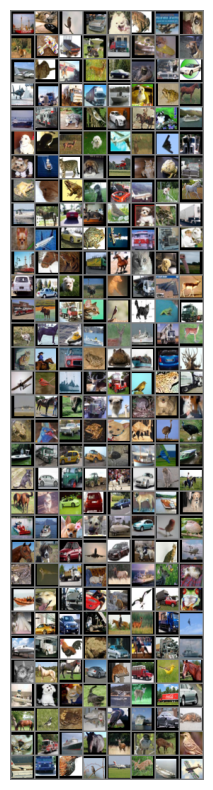

ship cat bird car dog frog plane dog deer plane truck dog truck frog dog dog plane cat truck deer car frog horse car plane truck truck truck ship dog frog horse ship truck cat bird car horse dog ship dog bird deer dog plane deer plane truck dog ship cat dog plane cat frog car frog cat frog bird car plane dog horse ship horse car cat bird dog frog truck dog plane car frog plane truck truck horse ship horse frog truck horse cat dog bird car car dog bird dog truck plane deer truck deer truck cat bird cat frog truck bird horse ship ship deer ship truck deer cat horse car frog frog ship car deer plane bird ship deer truck bird frog truck plane horse deer truck bird bird cat dog frog bird car frog dog deer bird bird ship truck car truck bird ship plane ship dog car truck truck horse car cat horse horse cat car car car dog ship dog ship ship dog dog ship car bird bird horse dog car plane car horse cat plane frog frog truck dog deer ship deer cat ship dog ship car cat bird truck frog cat car c

In [9]:
def imshow(img):
    img = img * 0.5 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images and first digit label
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:>2s}' for j in range(batch_size)))


In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [17]:
criterion = nn.CrossEntropyLoss()
lr = 0.005#*(batch_size/40)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(20):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item()
        
        # Track training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        if i % 20 == 19:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0
    
    # Store epoch metrics
    train_losses.append(epoch_loss / len(trainloader))
    train_accuracies.append(100 * correct_train / total_train)
    
    # Evaluate on test set AFTER EACH EPOCH
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_acc = 100 * correct / total
    test_accuracies.append(test_acc)
    print(f'Epoch {epoch + 1}: Test Acc: {test_acc:.2f}%\n')

print('Finished Training')

print('Finished Training')
PATH = './models/CIFAR10_net.pth'
torch.save(net.state_dict(), PATH)

[1,    20] loss: 0.861
[1,    40] loss: 0.868
[1,    60] loss: 0.858
[1,    80] loss: 0.861
[1,   100] loss: 0.860
[1,   120] loss: 0.904
[1,   140] loss: 0.866
[1,   160] loss: 0.857
[1,   180] loss: 0.901
Epoch 1: Test Acc: 67.25%

[2,    20] loss: 0.865
[2,    40] loss: 0.868
[2,    60] loss: 0.862
[2,    80] loss: 0.858
[2,   100] loss: 0.878
[2,   120] loss: 0.862
[2,   140] loss: 0.850
[2,   160] loss: 0.874
[2,   180] loss: 0.884
Epoch 2: Test Acc: 67.48%

[3,    20] loss: 0.839
[3,    40] loss: 0.871
[3,    60] loss: 0.837
[3,    80] loss: 0.865
[3,   100] loss: 0.856
[3,   120] loss: 0.873
[3,   140] loss: 0.870
[3,   160] loss: 0.868
[3,   180] loss: 0.882
Epoch 3: Test Acc: 67.65%

[4,    20] loss: 0.867
[4,    40] loss: 0.870
[4,    60] loss: 0.856
[4,    80] loss: 0.876
[4,   100] loss: 0.861
[4,   120] loss: 0.843
[4,   140] loss: 0.843
[4,   160] loss: 0.841
[4,   180] loss: 0.871
Epoch 4: Test Acc: 67.26%

[5,    20] loss: 0.869
[5,    40] loss: 0.867
[5,    60] loss: 0

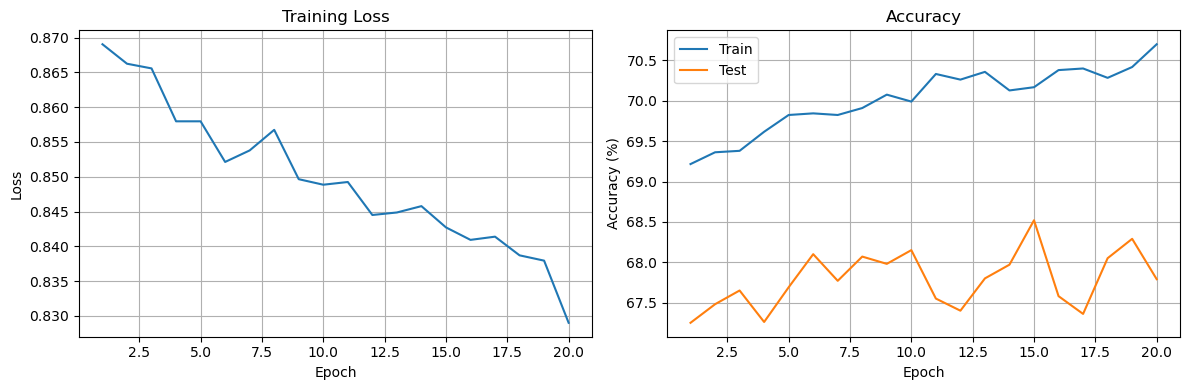

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(range(1, 21), train_losses)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

ax2.plot(range(1, 21), train_accuracies, label='Train')
ax2.plot(range(1, 21), test_accuracies, label='Test')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('./logs/training_stats.png', dpi=150)
plt.show()

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs) # Changed 'images' to 'inputs' to use the data already on the device
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')